In [ ]:
"""
Recorre un WSI
Modelo usado: Swin ViT Small v1
"""


'\nRecorre un WSI\nModelo usado: Swin ViT Small v1\n'

In [ ]:
import datetime
now = datetime.datetime.now()
hora_actual = datetime.datetime.now().hour -5
minuto_actual =datetime.datetime.now().minute
print(now.date())
print(f"{hora_actual}:{minuto_actual}")

2025-07-15
17:13


In [ ]:
# Conectar con Google Drivee()
from google.colab import drive
drive.mount('/content/drive')
base_folder = "/content/drive/MyDrive/00 VIU/10 TFM"
# importar credenciales de Hugging face
from google.colab import userdata
import os
from huggingface_hub import login

hf_token = userdata.get('HF_TOKEN')


Mounted at /content/drive


In [ ]:
# instalar las librerías
!pip install -q datasets evaluate keras_cv
!pip install --upgrade transformers
!pip install -q tensorflow
!pip install -q tf-keras

!pip install openslide-python
!pip install openslide-bin
!apt-get install openslide-tools
import os
if not os.environ.get('LD_LIBRARY_PATH'):
    os.environ['LD_LIBRARY_PATH'] = ''
os.environ['LD_LIBRARY_PATH'] += ':/usr/local/lib'

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 7.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 650.7/650.7 kB 40.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 950.8/950.8 kB 32.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.9/40.9 kB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.8/10.8 MB 56.9 MB/s eta 0:00:00
  Attempting uninstall: transformers
    Found existing installation: transformers 4.53.1
    Uninstalling transformers-4.53.1:
      Successfully uninstalled transformers-4.53.1
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.3/4.3 MB 75.4 MB/s eta 0:00:00
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  libopenslide0
Suggested packages:
  libtiff-tools
The following NEW packages will be installed:
  libopenslide0 openslide-tools
0 upgraded, 2 newly installed, 0 to remove and 35 not upgraded.
N

In [ ]:
import openslide
import matplotlib.pyplot as plt
import pickle
import transformers
import evaluate
from transformers import AutoModelForImageClassification, AutoImageProcessor,TrainingArguments, Trainer
import numpy as np

from PIL import Image as PILImage
import torch

In [ ]:
# VALIDAR SI SE CUENTA CON GPU PARA OPTIMIZAR EJECUCION
if torch.cuda.is_available():
    device = torch.device("cuda")
    print(f"GPU disponible: {torch.cuda.get_device_name(0)}")
else:
    device = torch.device("cpu")
    print("No hay GPU disponible, usando CPU.")


GPU disponible: Tesla T4


In [ ]:
# CARGAR EL MODELO DE CLASIFICACION DE PARCHES

model_path=base_folder+"/Modelos entrenados/Swin v1 Small 3epocas/checkpoint-2048"

# Cargar el image_processor:
image_processor = AutoImageProcessor.from_pretrained(model_path)
print("image processor cargado ok")
# Cargar el modelo
num_labels = 2
model = AutoModelForImageClassification.from_pretrained(
    model_path,
    num_labels=num_labels,
    ignore_mismatched_sizes = True
)
print("modelo cargado ok")

# Mover el modelo a la GPU:
model.to(device)


image processor cargado ok
modelo cargado ok


SwinForImageClassification(
  (swin): SwinModel(
    (embeddings): SwinEmbeddings(
      (patch_embeddings): SwinPatchEmbeddings(
        (projection): Conv2d(3, 128, kernel_size=(4, 4), stride=(4, 4))
      )
      (norm): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): SwinEncoder(
      (layers): ModuleList(
        (0): SwinStage(
          (blocks): ModuleList(
            (0): SwinLayer(
              (layernorm_before): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
              (attention): SwinAttention(
                (self): SwinSelfAttention(
                  (query): Linear(in_features=128, out_features=128, bias=True)
                  (key): Linear(in_features=128, out_features=128, bias=True)
                  (value): Linear(in_features=128, out_features=128, bias=True)
                  (dropout): Dropout(p=0.0, inplace=False)
                )
                (output): SwinSelfOutput(

In [15]:
# CARGAR UN WSI
ruta_wsi=base_folder+"/Datasets/CAMELYON16/images/patient_019_node_0.tif"


In [ ]:
# INICIALIZAR VARIABLES
patch_num,fila,col,cant_in_batch=0,0,0,0
lista_imgs,heatmap,list_filas,list_columnas,list_parches=[],[],[],[],[]
status=""


In [ ]:
# BUCLE PARA RECORRER EL WSI
# %%time
try:
    with openslide.OpenSlide(ruta_wsi) as slide:
        print(f"Archivo ok. Dimensiones del nivel 0: {slide.level_dimensions[0]}")
        # Leer un tile específico del nivel más bajo
        WSI_h=slide.level_dimensions[0][1]
        WSI_w=slide.level_dimensions[0][0]
        batch_p,p_size, haya_filas,haya_columnas,listado=32,224,True,True,[]


        while haya_filas:
          while haya_columnas:
            img = slide.read_region((col, fila), 1, (p_size, p_size))
            lista_imgs = lista_imgs+[img.convert('RGB')]
            list_filas.append(fila)
            list_columnas.append(col)
            list_parches.append(patch_num)
            cant_in_batch += 1

            if cant_in_batch == batch_p:
              # print(f"lote finalizado {patch_num//batch_p}; patch num: {patch_num}")
              inputs = image_processor(images=lista_imgs, return_tensors="pt")

              # Mover los inputs a la GPU:
              inputs = {k: v.to(device) for k, v in inputs.items()}

              model.eval() # Poner el modelo en modo de evaluación
              with torch.no_grad(): # Desactivar el cálculo de gradientes
                outputs = model(pixel_values=inputs['pixel_values'])
                logits = outputs.logits
                probs = torch.softmax(logits, dim=-1)
                listado = [float(probs[i,1]) for i in range(probs.shape[0])]
                heatmap = heatmap + listado
              lista_imgs = []
              cant_in_batch = 0
            else:
              pass
            patch_num += 1
            col += (p_size*2)
            haya_columnas = (col+p_size*2 <= WSI_w)



          fila += (p_size*2)
          col = 0
          haya_columnas = True
          haya_filas = (fila <= WSI_h)



          if fila%448 == 0 and (fila//448)%20 ==0:
            print(f"Porcentaje de avance: {fila/WSI_h:.0%}")


        status = "ok"

except openslide.OpenSlideError as e:
    print(f"Error al abrir el WSI: {e}")
except FileNotFoundError:
    print(f"Archivo no encontrado: {ruta_wsi}")


Archivo ok. Dimensiones del nivel 0: (94968, 210579)
Porcentaje de avance: 4%
Porcentaje de avance: 9%
Porcentaje de avance: 13%
Porcentaje de avance: 17%
Porcentaje de avance: 21%
Porcentaje de avance: 26%
Porcentaje de avance: 30%
Porcentaje de avance: 34%
Porcentaje de avance: 38%
Porcentaje de avance: 43%
Porcentaje de avance: 47%
Porcentaje de avance: 51%
Porcentaje de avance: 55%
Porcentaje de avance: 60%
Porcentaje de avance: 64%
Porcentaje de avance: 68%
Porcentaje de avance: 72%
Porcentaje de avance: 77%
Porcentaje de avance: 81%
Porcentaje de avance: 85%
Porcentaje de avance: 89%
Porcentaje de avance: 94%
Porcentaje de avance: 98%


Tiempo de ejecución: 1:26:26.364781
parches por fila:  211
tamaño heatmap_np:  (471, 211)


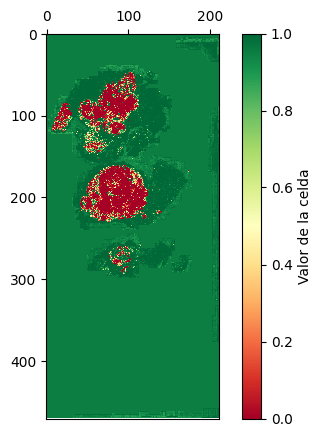

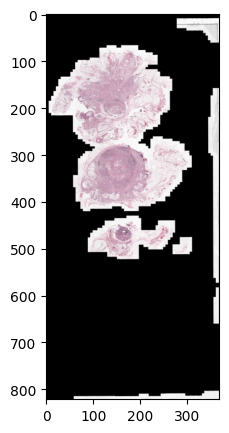


Rangos (bins): [0.0, 0.2, 0.4, 0.6, 0.8, 1.0]
Conteo de datos en cada rango: [91654   607   459   548  6092]


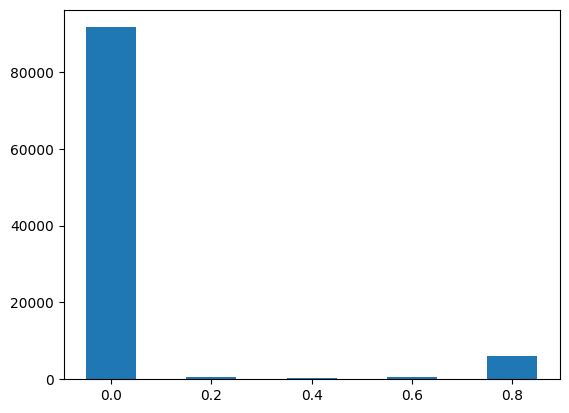

In [ ]:
end_time = datetime.datetime.now()
print(f"Tiempo de ejecución: {end_time - now}")

# Guardar las variables en archivo:
if status == "ok":
 variables={'WSI_h':WSI_h,
           'WSI_w':WSI_w,
            'patch_num':patch_num,
            'fila':fila,
            'col':col,
            'cant_in_batch':cant_in_batch,
            'lista_imgs':lista_imgs,
            'heatmap':heatmap,
            'list_filas':list_filas,
            'list_columnas':list_columnas,
            'list_parches':list_parches
          }
 path_variables= base_folder+"/TFM Notebooks/Dumps de variables y objetos/variables WSI.pkl"
 with open(path_variables, 'wb') as archivo:
          pickle.dump(variables, archivo)

 p_max_ancho= WSI_w//(p_size*2)
 print("parches por fila: ",p_max_ancho)
 heatmap2=[]

 if len(heatmap)%p_max_ancho !=0:
   ult=((len(heatmap)//p_max_ancho)+1)*p_max_ancho - len(heatmap)
   list_append=[0]*ult
   heatmap2=heatmap+list_append
 else:
  heatmap2=heatmap
 heatmapc = [1-x for x in heatmap2]
 heatmap_np=np.array(heatmapc).reshape(len(heatmapc)//p_max_ancho,p_max_ancho)
 print("tamaño heatmap_np: ",heatmap_np.shape)

 # VISUALIZAR EL MAPA DE CALOR
 fig, ax = plt.subplots(figsize=(6, 5))
 im=ax.imshow(heatmap_np,cmap='RdYlGn',interpolation='nearest',origin="upper",vmin=0,vmax=1)
 ax.xaxis.tick_top() # Mueve los ticks del eje X a la parte superior
 ax.xaxis.set_label_position('top') # Mueve la etiqueta del eje X a la parte superior

 fig.colorbar(im,label="Valor de la celda")
 plt.savefig(base_folder+"/TFM Notebooks/Dumps de variables y objetos/heatmap.png",dpi=1200)
 plt.show()

 # VISUALIZAR LA IMAGEN DEL WSI
 with openslide.OpenSlide(ruta_wsi) as slide:
        thumb = slide.read_region((0,0), 8,slide.level_dimensions[8] )
 fig, ax = plt.subplots(figsize=(6, 5))
 im=ax.imshow(thumb)
 plt.savefig(base_folder+"/TFM Notebooks/Dumps de variables y objetos/heatmap.png",dpi=1200)
 plt.show()

 # VISUALIZAR LOS BUCKETS DE DISTRIBUCION DE PROBABILIDADES
 data = np.array(heatmap)
 bins = [0.0, 0.2, 0.4, 0.6, 0.8, 1.0]
 counts, _ = np.histogram(data, bins=bins)
 print("\nRangos (bins):", bins)
 print("Conteo de datos en cada rango:", counts)
 plt.bar(bins[0:5],counts,width=0.1)
 plt.xlabel=bins[0:5]